# figures_draft2017a.ipynb

## Purpose
Produce figures for /"Radiative effects of anthropogenic aerosol emissions from different source regions"/.

## Dependencies
- TODO

## Data requirements
- TODO

## Author
Benjamin S. Grandey, 2017

In [1]:
! date

Mon Nov 20 18:38:29 +08 2017


In [2]:
import climapy
import lib_draft2017a
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import os
import pandas as pd
import xarray as xr

# Print versions of dependencies
for package in [climapy, np, pd, xr]:
    try:
        print('{}.__version__ = {}'.format(package.__name__, package.__version__))
    except AttributeError:
        pass
print('lib_draft2017a.py is using {}'.format(lib_draft2017a.dependency_versions()))

%matplotlib inline
matplotlib.rcParams['figure.dpi']= 40  # reduce resolution of inline figures

climapy.__version__ = 0.1.0+b35937c
numpy.__version__ = 1.13.3
pandas.__version__ = 0.21.0
xarray.__version__ = 0.9.6
lib_draft2017a.py is using {'climapy': '0.1.0+b35937c', 'pandas': '0.21.0', 'xarray': '0.9.6'}


In [3]:
# Load dictionaries etc from lib_draft2017a
region_bounds_dict = lib_draft2017a.load_region_bounds_dict()
region_long_dict = lib_draft2017a.load_region_long_dict()
scenario_name_dict = lib_draft2017a.load_scenario_name_dict()

In [4]:
# Initialise counters to keep track of figure numbers
figure_counter = 1  # main manuscript
supplementary_figure_counter = 1  # supplementary figures

## Map of regions

Written local/f01.pdf


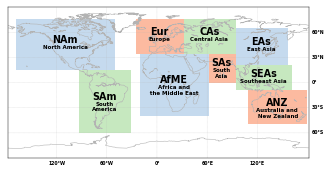

In [5]:
# Load sample data
sample_data = lib_draft2017a.load_output('BURDENSO4', scenario='p16a_F_Hist_2000',
                                         season='annual').isel(year=0).copy()
# Set sample data equal to one - here, we are just interested in lat-lon info
sample_data[:] = 1.
# Shift longitudes
sample_data = climapy.xr_shift_lon(sample_data, lon_min=-179)
# Longitude and latitude data
lon = sample_data['lon']
lat = sample_data['lat']
# Lower bound for first longitude bin (important for map)
lon0 = (lon[0] - (lon[1]-lon[0])/2.0).values
# Pseudo-lower bound for first latitude bin (used for stretching imshow)
lat0 = (lat[0] - (lat[1]-lat[0])/2.0).values
# Set-up plot
fig = plt.figure(figsize=(8.0, 6.0))
bm = Basemap(llcrnrlat=-90.0, urcrnrlat=90.0, llcrnrlon=lon0, urcrnrlon=lon0+360.0)
bm.drawcoastlines(color='0.7')
bm.drawparallels([-60, -30, 0, 30, 60], labels=[0, 1, 0, 0], fontsize='small',
                  fontweight='bold', color='0.7', linewidth=0.5)
bm.drawmeridians([-120, -60, 0, 60, 120], labels=[0, 0, 0, 1], fontsize='small',
                  fontweight='bold', color='0.7', linewidth=0.5)
# Plot region masks and names
for region, region_bounds in region_bounds_dict.items():
    lon_bounds, lat_bounds = region_bounds
    # Get long name of region
    long_name = region_long_dict[region]
    if region in ['SAm', 'SAs']:  # split long name over two lines if necessary
        long_name = '\n'.join(long_name.split(' '))
    if region in ['AfME', 'ANZ']:
        long_name = 'and\n'.join(long_name.split('and'))
    # Set colour map
    if region in ['NAm', 'AfME', 'EAs']:  # shading colour dependent on region
        cmap = 'Blues'
    elif region in ['SAm', 'CAs', 'SEAs']:
        cmap = 'Greens'
    else:
        cmap = 'Reds'
    # Create data for region using sample_data
    region_data = sample_data.copy()
    region_data = climapy.xr_mask_bounds(region_data, select_how='inside',  # mask
                                         lon_bounds=lon_bounds, lat_bounds=lat_bounds)
    # Plot data and annotations
    if lon_bounds is not None:
        plt.imshow(region_data, extent=[lon0, 360+lon0, -lat0, lat0],
                   interpolation='Nearest', cmap=cmap,
                   vmin=0, vmax=4)
        label_pos = [(lon_bounds[0]+lon_bounds[1])/2,
                     (lat_bounds[0]+lat_bounds[1])/2]
        plt.text(label_pos[0], label_pos[1], region,  # short name
                 color='k', weight='bold', fontsize='xx-large',
                 horizontalalignment='center', verticalalignment='bottom')
        plt.text(label_pos[0], label_pos[1], long_name,  # long name
                 color='k', weight='bold',
                 horizontalalignment='center', verticalalignment='top')
# Save figure
fig.tight_layout()
plt.savefig('local/f{:02}.pdf'.format(figure_counter), bbox_inches='tight', dpi=300)
print('Written local/f{:02}.pdf'.format(figure_counter))
figure_counter += 1

## Load global emissions data

In [6]:
# Load global emissions for different scenarios into dataframe
global_emissions_df = pd.DataFrame(columns=('scenario', 'scenario_name',
                                            'species', 'global_total'))
# Loop over scenarios and variables
for scenario, scenario_name in scenario_name_dict.items():
    # Load emissions for organic carbon (g/m2/yr)
    oc_both = lib_draft2017a.load_emissions('oc', 'both', scenario=scenario[7:])
    # Load emissions for black carbon (g/m2/yr)
    bc_both = lib_draft2017a.load_emissions('bc', 'both', scenario=scenario[7:])
    # Load emissions for sulphur species (g(S)/m2/yr)
    so2_both = lib_draft2017a.load_emissions('so2', 'both', scenario=scenario[7:])
    so4_a1_surf = lib_draft2017a.load_emissions('so4_a1', 'surf', scenario=scenario[7:])
    so4_a1_elev = lib_draft2017a.load_emissions('so4_a1', 'elev', scenario=scenario[7:])
    if scenario[0:6] == 'p17b_F':  # intended so4_a2 emissions
        so4_a2_surf = lib_draft2017a.load_emissions('so4_a2', 'surf', scenario=scenario[7:])
    else:  # due to bug
        so4_a2_surf = lib_draft2017a.load_emissions('so4_a1', 'surf', scenario=scenario[7:])
    so4_a2_elev = lib_draft2017a.load_emissions('so4_a2', 'elev', scenario=scenario[7:])
    dms = lib_draft2017a.load_emissions('dms', 'both')
    # Sum emissions for sulphur species
    s_both = so2_both + so4_a1_surf + so4_a1_elev + so4_a2_surf + so4_a2_elev + dms
    # Calculate global totals (Tg/yr)
    s_global = climapy.xr_area_weighted_stat(s_both, stat='sum').values / 1e12
    oc_global = climapy.xr_area_weighted_stat(oc_both, stat='sum').values / 1e12
    bc_global = climapy.xr_area_weighted_stat(bc_both, stat='sum').values / 1e12
    # Store global totals in dataframe
    for species, global_total in zip(['S', 'OC', 'BC'], [s_global, oc_global, bc_global]):
        global_emissions_df = global_emissions_df.append({'scenario': scenario, 
                                                          'scenario_name': scenario_name,
                                                          'species': species,
                                                          'global_total': global_total},
                                                         ignore_index=True)
global_emissions_df.head()

,scenario,scenario_name,species,global_total
0,p16a_F_Hist_2000,All1,S,84.596255
1,p16a_F_Hist_2000,All1,OC,35.889499
2,p16a_F_Hist_2000,All1,BC,7.758681
3,p16a_F_Zero_2000,All0,S,32.718225
4,p16a_F_Zero_2000,All0,OC,23.188555


In [7]:
# Print emissions for All0
global_emissions_df[(global_emissions_df['scenario_name'] == 'All0')]

,scenario,scenario_name,species,global_total
3,p16a_F_Zero_2000,All0,S,32.718225
4,p16a_F_Zero_2000,All0,OC,23.188555
5,p16a_F_Zero_2000,All0,BC,2.608787


In [8]:
# For emissions, calculate differences from reference scenarios
def diff_according_to_scenario_name_for_emissions(row):
    """
    For emissions, calculate difference according to scenario name.
    
    Args:
        row: row of the global_emissions_df DataFrame.
    
    Returns:
        Modified version of row containing 'scenario_diff' and 'global_diff'.
    """
    scenario_name = row['scenario_name']
    if scenario_name[-1] == '1':  # if ends with '1', compare to All0
        ref_name = 'All0'
    else:  # if ends with '0', compare to All1
        ref_name = 'All1'
    ref_row = global_emissions_df[(global_emissions_df['species'] == row['species']) &
                                  (global_emissions_df['scenario_name'] == ref_name)
                                 ].T.squeeze()  # DataFrame to Series
    if ref_name == 'All0':
        scenario_diff = '{}-All0'.format(scenario_name)
        global_diff = row['global_total'] - ref_row['global_total']
    else:
        scenario_diff = 'All1-{}'.format(scenario_name)
        global_diff = ref_row['global_total'] - row['global_total']
    row['ref_name'] = ref_name
    row['scenario_diff'] = scenario_diff
    row['global_diff'] = global_diff
    return row

diff_emissions_df = global_emissions_df.apply(diff_according_to_scenario_name_for_emissions,
                                              axis=1)  # apply function above
diff_emissions_df.head()

,scenario,scenario_name,species,global_total,ref_name,scenario_diff,global_diff
0,p16a_F_Hist_2000,All1,S,84.596255,All0,All1-All0,51.878029
1,p16a_F_Hist_2000,All1,OC,35.889499,All0,All1-All0,12.700944
2,p16a_F_Hist_2000,All1,BC,7.758681,All0,All1-All0,5.149895
3,p16a_F_Zero_2000,All0,S,32.718225,All1,All1-All0,51.878029
4,p16a_F_Zero_2000,All0,OC,23.188555,All1,All1-All0,12.700944


## Emissions barcharts

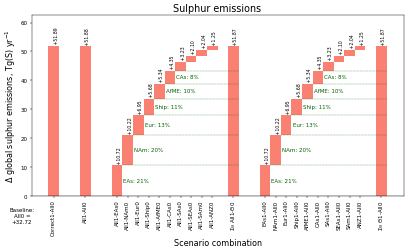

In [9]:
# Function to produce staggered barcharts for a given emissions species
def emissions_staggered_barcharts(species='S', title='Sulphur emissions',
                                  ylabel=r'$\Delta$ global sulphur emissions, Tg(S) yr$^{-1}$',
                                  text_format=r' {:+.2f}', y_stretch=1.15,
                                  n_contributors='auto'):
    # Get subset of relevant data from diff_emissions_df
    bars_df = diff_emissions_df[(diff_emissions_df['species'] == species)]
    # Delete repeat of All1-All0
    bars_df = bars_df[(bars_df['scenario_name'] != 'All0') | (bars_df['ref_name'] != 'All1')]
    # Set scenario_diff as index, after changing dtype to object (to facilitate easier appending)
    bars_df['scenario_diff'] = bars_df['scenario_diff'].astype('object')
    bars_df = bars_df.set_index('scenario_diff')
    # Add 'bottom' column and 'x' position column, both initialised as NaNs
    bars_df = bars_df.assign(bottom=np.nan, x=np.nan)
    # x position and bottom for first two bars
    bars_df.loc['Correct1-All0', 'x'] = 0  # 1st bar
    bars_df.loc['Correct1-All0', 'bottom'] = 0
    bars_df.loc['All1-All0', 'x'] = 3  # 2nd bar
    bars_df.loc['All1-All0', 'bottom'] = 0
    # 1st set of staggered bars
    order1 = (bars_df[(bars_df['ref_name'] == 'All1') &  # order All1-<Source>0 by global_diff
                      (bars_df['scenario_name'] != 'All0')].
              sort_values(by='global_diff', ascending=False).index)
    bars_df.loc[order1, 'x'] = np.arange(len(order1)) + max(bars_df['x']) + 3
    for i in (range(len(order1))):
        if i == 0:
            bars_df.loc[order1[i], 'bottom'] = 0
        else:
            bars_df.loc[order1[i], 'bottom'] = (bars_df.loc[order1[i-1], 'bottom'] +
                                                bars_df.loc[order1[i-1], 'global_diff'])
    # 1st combined bar
    global_diff = bars_df.loc[order1, 'global_diff'].sum()
    bars_df = bars_df.append(pd.Series({'global_diff': global_diff,
                                        'x': max(bars_df['x'])+2, 'bottom': 0},
                                       name=r'$\Sigma_{\Theta}$ All1-$\Theta$0'))
    # 2nd set of staggered bars
    order2 = (bars_df[(bars_df['ref_name'] == 'All0') &  # order <Source>1-All0 by global_diff
                      (bars_df['scenario_name'] != 'All1') &
                      (bars_df['scenario_name'] != 'Correct1')].
              sort_values(by='global_diff', ascending=False).index)
    bars_df.loc[order2, 'x'] = np.arange(len(order2)) + max(bars_df['x']) + 3
    for i in (range(len(order2))):
        if i == 0:
            bars_df.loc[order2[i], 'bottom'] = 0
        else:
            bars_df.loc[order2[i], 'bottom'] = (bars_df.loc[order2[i-1], 'bottom'] +
                                                bars_df.loc[order2[i-1], 'global_diff'])
    # 2nd combined bar
    global_diff = bars_df.loc[order2, 'global_diff'].sum()
    bars_df = bars_df.append(pd.Series({'global_diff': global_diff,
                                        'x': max(bars_df['x'])+2, 'bottom': 0},
                                       name=r'$\Sigma_{\Theta}$ $\Theta$1-All0'))
    # Add colour based on whether -ve or +ve
    bars_df = bars_df.assign(color='salmon')  # all bars are +ve
    # Plot barchart
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(bars_df['x'], bars_df['global_diff'], bottom=bars_df['bottom'],
           width=1., color=bars_df['color'])
    # Axes and title
    plt.axhline(y=0, linewidth=0.5, color='k', alpha=0.5)
    ax.set_xticks(bars_df['x'])
    ax.set_xticklabels(bars_df.index, rotation=90)
    ax.set_xlabel('Scenario combination', fontsize='x-large')
    ax.set_ylabel(ylabel, fontsize='x-large')
    ax.set_ylim([y * y_stretch for y in ax.get_ylim()])  # manually stretch y-axis to accommodate annotations
    ax.set_title(title, fontsize='xx-large')
    # Annotate with values
    for scenario in bars_df.index:
        text = text_format.format(bars_df.loc[scenario, 'global_diff'])
        if bars_df.loc[scenario, 'global_diff'] > 0:
            verticalalignment='bottom'
        else:
            verticalalignment='top'
        ax.text(bars_df.loc[scenario, 'x'], bars_df.loc[scenario, ['bottom', 'global_diff']].sum(),
                text, rotation=90, verticalalignment=verticalalignment, fontsize='small')
    # Annotate combined bars with largest contributing sources
    for scenario, order, ref_name in zip([r'$\Sigma_{\Theta}$ All1-$\Theta$0',
                                          r'$\Sigma_{\Theta}$ $\Theta$1-All0'],
                                         [order1, order2], ['All1', 'All0']):
        if n_contributors == 'auto':
            n = 0  
            perc_sum = 0  # % contribution accounted for so far
            for s in order:
                perc_sum += bars_df.loc[s, 'global_diff'] / bars_df.loc[scenario, 'global_diff'] * 100
                if perc_sum > 100 or perc_sum < 0:
                    break
                elif perc_sum > 80:
                    n += 1
                    break
                else:
                    n += 1
        else:
            n = n_contributors
        for s in order[0:n]:
            y_pos = bars_df.loc[s, ['global_diff', 'bottom']].sum()
            ax.plot([bars_df.loc[s, 'x']+0.5, bars_df.loc[scenario, 'x']+0.5],  # draw horizontal line
                    [y_pos, y_pos], color='darkgreen', linestyle='--', linewidth=0.5)
            perc = bars_df.loc[s, 'global_diff'] / bars_df.loc[scenario, 'global_diff'] * 100  # % contribution
            if ref_name == 'All1':
                source = s.split('-')[1][:-1]
            else:
                source = s.split('-')[0][:-1]
            text = '{}: {:.0f}%'.format(source, perc)
            text_y_pos = bars_df.loc[s, 'bottom'] + (bars_df.loc[s, 'global_diff'] / 2)
            ax.text(bars_df.loc[s, 'x']+0.6, text_y_pos, text,
                    verticalalignment='center', horizontalalignment='left',
                    color='darkgreen')
    # Annotate with All0 baseline
    all0_baseline = global_emissions_df[(global_emissions_df['scenario_name'] == 'All0') &
                                        (global_emissions_df['species'] == species)
                                       ]['global_total']
    ax.text(-3, 0, '\n\nBaseline:\nAll0 =\n{:+.2f}'.format(float(all0_baseline)),
            horizontalalignment='center', verticalalignment='top')
    return fig, ax

# Example
if True:
    fig, ax = emissions_staggered_barcharts()